# Simple Imitation Learning

In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from models.mlp import MLP
from models.autoencoders import AE
from trainers.standard import train
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.waypoint_extraction import pickplace_task_waypoints

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 256
LATENT_DIM = 6
AE_PATH = "./logs/models/autoencoder_2024-10-21_15:24/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Device Name: NVIDIA GeForce RTX 3090


In [3]:
image_encoder = AE(latent_dim=LATENT_DIM).to(device=device)
image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))

# Create the input data: latent representation of initial scene images
X = []
for im_path in tqdm(im_paths):
    image = cv2.imread(im_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
    image = image/255.0
    image = np.transpose(image, (2, 0, 1))  # HWC to CHW
    latent = image_encoder.encode(torch.Tensor(np.array([image])).to(device))
    X.append(latent[0].cpu().detach().numpy())

X = np.array(X)
print(X.shape)

/tmp/ipykernel_11480/2277165131.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))
100%|██████████| 

(4911, 6)


In [4]:
dirs = os.listdir(DATA_PATH)

# Create output data: waypoint collections from the paths
ways = []
for ep_path in tqdm(dirs):
    pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
    ways.append(pickplace_task_waypoints(pos, gripper_widths))
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
print(y.shape)

100%|██████████| 4911/4911 [02:52<00:00, 28.50it/s]

(4911, 9)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

errors = y_test - y_pred
errors = errors[:, :2]
errors = [np.linalg.norm(e) for e in errors]
mean_error = sum(errors)/len(errors)
devs = [abs(e-mean_error) for e in errors]
dev_error = sum(devs)/len(devs)

print("Avg. dist. from desired point (m): ", mean_error)
print("Avg. dev. from desired point (m): ", dev_error)

Avg. dist. from desired point (m):  0.0820773749914718
Avg. dev. from desired point (m):  6.828775140020196e-17


/tmp/ipykernel_11480/2747056312.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  image = image_encoder.decode(torch.Tensor([latent]).to(device))


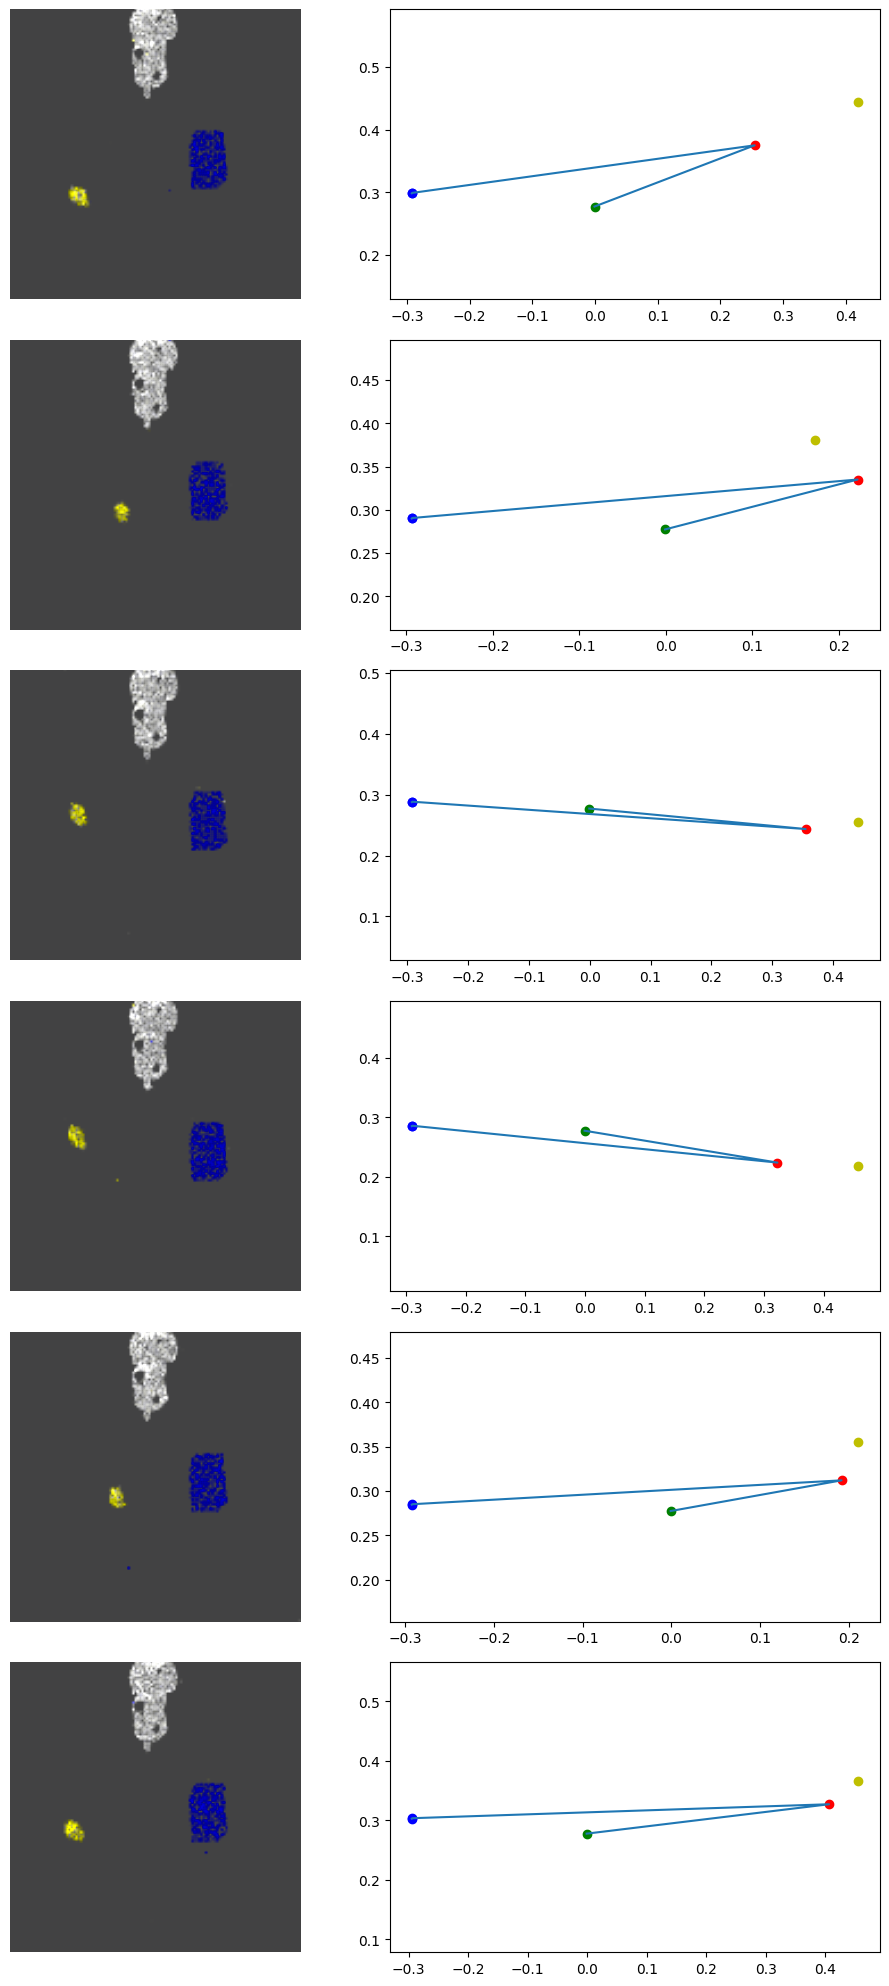

In [6]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

fig, axes = plt.subplots(example_count, 2, figsize=(10, 20))
for i in range(example_count):
    latent = X_test[rand_indices[i]]
    image = image_encoder.decode(torch.Tensor([latent]).to(device))
    image = image.detach().cpu().numpy()
    image = np.maximum(image, 0)
    image = np.minimum(image, 1)
    image = np.transpose(image, (0, 2, 3, 1))
    axes[i, 0].imshow(image[0])

    ways = ridge_model.predict([latent])
    ways = ways[0].reshape(-1, 3)
    start_way = np.array([-8.28538e-04, 2.77307e-01, 1.26312e+00])

    axes[i, 1].scatter([start_way[0]], [start_way[1]], c="g")
    axes[i, 1].scatter(ways[1:3][:, 0], ways[1:3][:, 1], c="b")
    axes[i, 1].scatter(ways[:, 0][0], ways[:, 1][0], c="r")

    axes[i, 1].scatter(y_test[rand_indices[i]][0], y_test[rand_indices[i]][1], c="y")

    ways = np.insert(ways, 0, start_way, axis=0)
    axes[i, 1].plot(ways[:, 0], ways[:, 1])

    axes[i, 0].axis('off')
    axes[i, 1].axis('equal')
plt.tight_layout()
plt.show()

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [8]:
mlp_model = MLP(X_train.shape[1], y_train.shape[1], hidden_layers=[16, 16, 16])
mlp_model = train(mlp_model, device, train_loader, val_loader, n_epochs=2000, lr=1e-4)

Epoch 1,	 Train Loss: 0.522396,	 Val Loss: 0.399496
Epoch 2,	 Train Loss: 0.458144,	 Val Loss: 0.361849
Epoch 3,	 Train Loss: 0.410517,	 Val Loss: 0.331973
Epoch 4,	 Train Loss: 0.370144,	 Val Loss: 0.307415
Epoch 5,	 Train Loss: 0.339521,	 Val Loss: 0.285628
Epoch 6,	 Train Loss: 0.313441,	 Val Loss: 0.266481
Epoch 7,	 Train Loss: 0.289706,	 Val Loss: 0.248540
Epoch 8,	 Train Loss: 0.271581,	 Val Loss: 0.231531
Epoch 9,	 Train Loss: 0.252416,	 Val Loss: 0.214510
Epoch 10,	 Train Loss: 0.235119,	 Val Loss: 0.197317
Epoch 11,	 Train Loss: 0.217475,	 Val Loss: 0.179895
Epoch 12,	 Train Loss: 0.203607,	 Val Loss: 0.162479
Epoch 13,	 Train Loss: 0.189247,	 Val Loss: 0.145795
Epoch 14,	 Train Loss: 0.175355,	 Val Loss: 0.129509
Epoch 15,	 Train Loss: 0.160338,	 Val Loss: 0.114889
Epoch 16,	 Train Loss: 0.147103,	 Val Loss: 0.102095
Epoch 17,	 Train Loss: 0.140294,	 Val Loss: 0.091230
Epoch 18,	 Train Loss: 0.129941,	 Val Loss: 0.081769
Epoch 19,	 Train Loss: 0.119337,	 Val Loss: 0.074245
Ep

In [11]:
y_pred = mlp_model(torch.Tensor(X_test).to(device)).cpu().detach().numpy()

errors = y_test - y_pred
errors = errors[:, :2]
errors = [np.linalg.norm(e) for e in errors]
mean_error = sum(errors)/len(errors)
devs = [abs(e-mean_error) for e in errors]
dev_error = sum(devs)/len(devs)

print("Avg. dist. from desired point (m): ", mean_error)
print("Avg. dev. from desired point (m): ", dev_error)

Avg. dist. from desired point (m):  0.023402220290470687
Avg. dev. from desired point (m):  0.013286914110649757


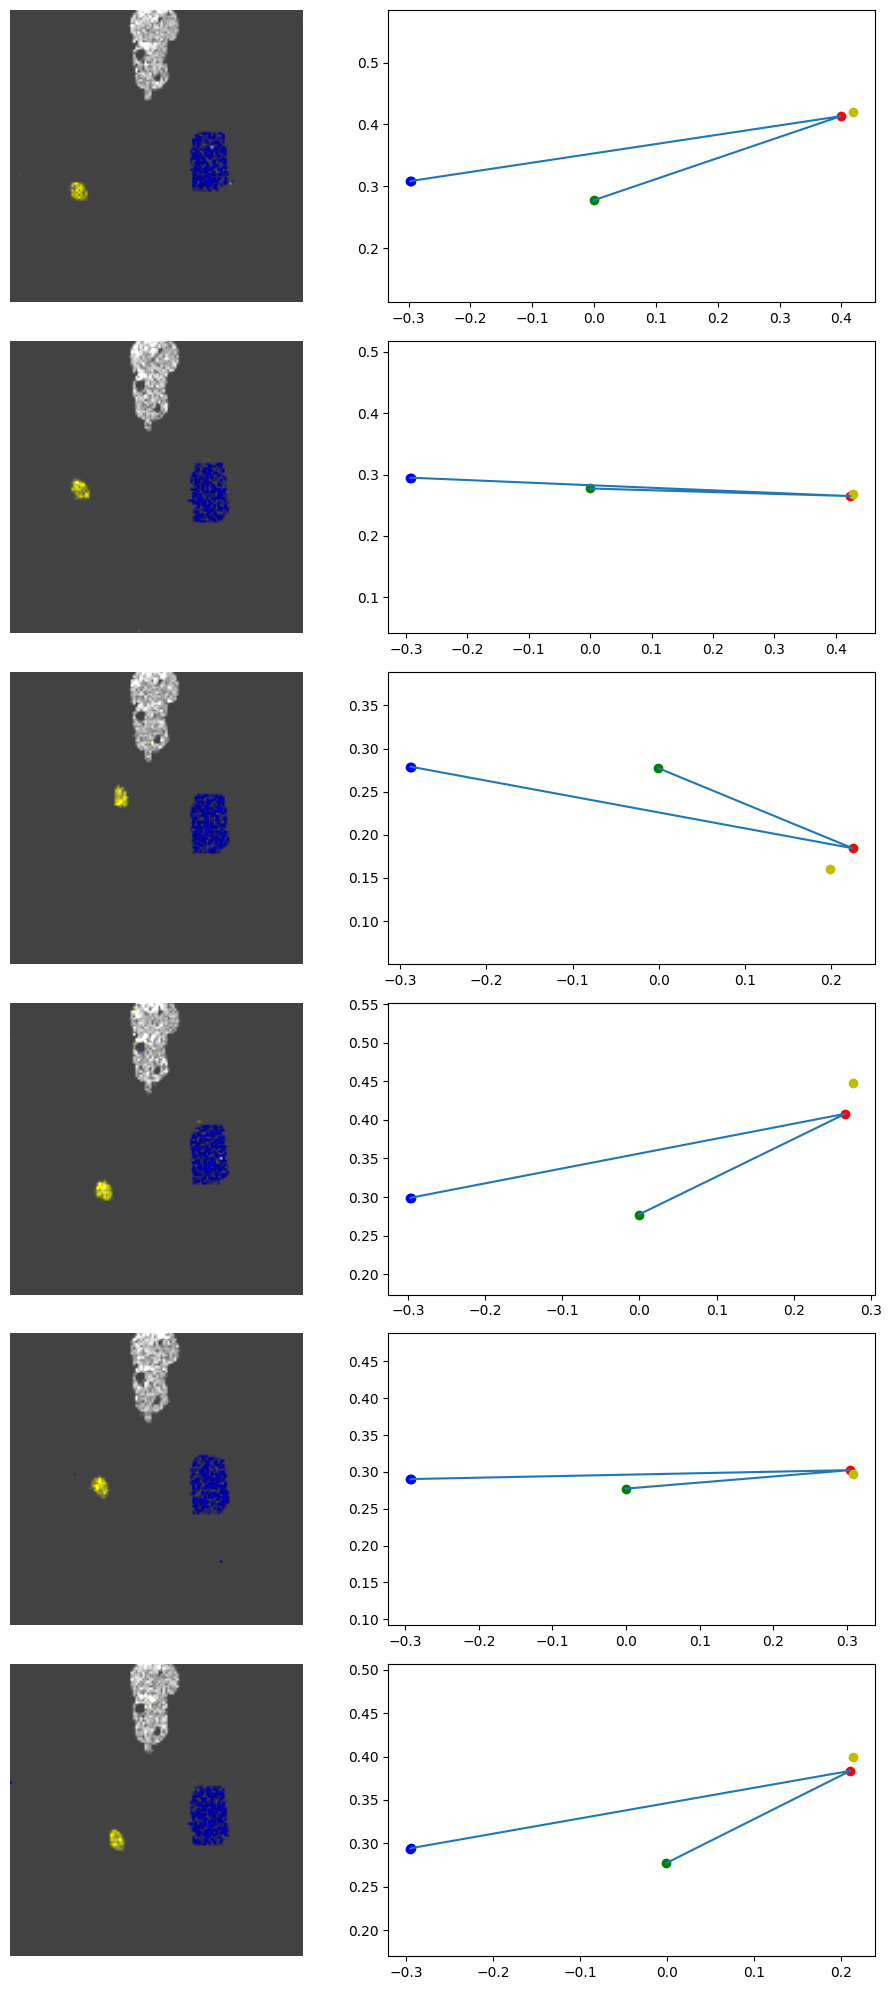

In [10]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

fig, axes = plt.subplots(example_count, 2, figsize=(10, 20))
for i in range(example_count):
    latent = X_test[rand_indices[i]]
    latent = torch.Tensor([latent]).to(device)
    image = image_encoder.decode(latent)
    image = image.detach().cpu().numpy()
    image = np.maximum(image, 0)
    image = np.minimum(image, 1)
    image = np.transpose(image, (0, 2, 3, 1))
    axes[i, 0].imshow(image[0])

    ways = mlp_model(latent).cpu().detach().numpy()
    ways = ways[0].reshape(-1, 3)
    start_way = np.array([-8.28538e-04, 2.77307e-01, 1.26312e+00])

    axes[i, 1].scatter([start_way[0]], [start_way[1]], c="g")
    axes[i, 1].scatter(ways[1:3][:, 0], ways[1:3][:, 1], c="b")
    axes[i, 1].scatter(ways[:, 0][0], ways[:, 1][0], c="r")

    axes[i, 1].scatter(y_test[rand_indices[i]][0], y_test[rand_indices[i]][1], c="y")

    ways = np.insert(ways, 0, start_way, axis=0)
    axes[i, 1].plot(ways[:, 0], ways[:, 1])

    axes[i, 0].axis('off')
    axes[i, 1].axis('equal')
plt.tight_layout()
plt.show()